In [1]:
import pandas as pd
import quantstats as qs
from datetime import datetime, timedelta
import pandas_market_calendars as mcal
import sys
import numpy
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
numpy.set_printoptions(threshold=sys.maxsize)

**Importando dados e inserindo o dia como coluna**

In [2]:
dados_empresas = pd.read_csv("historico_acoes.csv")
dados_empresas['data'] = pd.to_datetime(dados_empresas['data'])
dados_empresas = dados_empresas.set_index('data')
dados_empresas['day'] = dados_empresas.index.day

**Importando o calendário da B3 com os dias em que houveram negociações**

In [24]:
calendar = mcal.get_calendar('B3')
dias = calendar.valid_days(start_date = '2011-10-01', end_date = '2023-09-30')
dias = pd.DataFrame({'Dias': dias})
dias = dias.set_index('Dias')
dias['year'] = dias.index.year
dias['month'] = dias.index.month
dias['day'] = dias.index.day
dias

,year,month,day
Dias,,,
2011-10-03 00:00:00+00:00,2011,10,3
2011-10-04 00:00:00+00:00,2011,10,4
2011-10-05 00:00:00+00:00,2011,10,5
2011-10-06 00:00:00+00:00,2011,10,6
2011-10-07 00:00:00+00:00,2011,10,7
...,...,...,...
2023-09-25 00:00:00+00:00,2023,9,25
2023-09-26 00:00:00+00:00,2023,9,26
2023-09-27 00:00:00+00:00,2023,9,27


**Filtrando o último dia de negociação de cada mês**

In [25]:
ultimo_dia = dias.groupby([dias['year'], dias['month']]).idxmax()
ultimo_dia = ultimo_dia['day'].reset_index()['day']
ultimo_dia = pd.DataFrame(index=ultimo_dia)
ultimo_dia = ultimo_dia.index.strftime('%Y-%m-%d')
ultimo_dia

Index(['2011-10-31', '2011-11-30', '2011-12-29', '2012-01-31', '2012-02-29',
       '2012-03-30', '2012-04-30', '2012-05-31', '2012-06-29', '2012-07-31',
       ...
       '2022-12-29', '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-28',
       '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-29'],
      dtype='object', name='day', length=144)

**Função para filtrar uma base de dados pelos últimos dias de cada mês do calendário da B3**

In [26]:
def seleciona_filtro(dados):
    A = dados.index.strftime('%Y-%m-%d')
    B = list(set(A) & set(ultimo_dia))
    mask = dados.index.isin(B)
    dados = dados[mask]
    return dados

**Aplicando a função a base de dados das empresas**

In [27]:
dados_empresas_filtrado = dados_empresas.groupby('ticker').apply(seleciona_filtro)
dados_empresas_filtrado.reset_index(level=[0], drop = True, inplace = True)
dados_empresas_filtrado.head()

**Calculando os retornos mensais das ações entre os dias de negociação e aplicando um cálculo de retorno médio mensal**

(Algumas ações apresentam _gap_ entre um mês e outro, sendo necessário a conversão para retorno mensal)

In [29]:
dados_empresas_filtrado['retorno'] = dados_empresas_filtrado.groupby('ticker')['fechamento_ajustado'].pct_change()
dados_empresas_filtrado['retorno'] = dados_empresas_filtrado.groupby('ticker')['retorno'].shift(-1)

dados_empresas_filtrado['diferenca'] = (dados_empresas_filtrado.index - pd.Series(dados_empresas_filtrado.index).shift()).values
dados_empresas_filtrado['diferenca'] = (dados_empresas_filtrado['diferenca'] / timedelta(days=1)).shift(-1)
dados_empresas_filtrado.dropna(inplace=True)
dados_empresas_filtrado['retorno_medio_mensal'] = (1 + dados_empresas_filtrado['retorno']) ** (30 / dados_empresas_filtrado['diferenca']) - 1

dados_empresas.dropna(inplace=True)
dados_empresas_filtrado.dropna(inplace=True)
dados_empresas_filtrado

**Criando um ranking com os indicadores para realizar a seleção da carteira a partir dos melhores indicadores**

In [32]:
dados_empresas_filtrado['ranking_ev_ebit'] = dados_empresas_filtrado.groupby('data')['EBIT_EV'].rank(ascending = False)
dados_empresas_filtrado['ranking_roic'] = dados_empresas_filtrado.groupby('data')['ROIC'].rank(ascending = False)

dados_empresas_filtrado['ranking_final'] = dados_empresas_filtrado['ranking_ev_ebit'] + dados_empresas_filtrado['ranking_roic']
dados_empresas_filtrado['ranking_final'] = dados_empresas_filtrado.groupby('data')['ranking_final'].rank()

**Filtragem da base de dados para manter apenas as 10 melhores ações**

In [34]:
carteira_top_10_filtrado = dados_empresas_filtrado[dados_empresas_filtrado['ranking_final'] <= 10]
carteira_top_10_filtrado

**Cálculo de rentabilidade da carteira selecionada considerando pesos iguais**

In [48]:
rentabilidade_carteira = carteira_top_10_filtrado.groupby('data')['retorno_medio_mensal'].mean()
rentabilidade_carteira = rentabilidade_carteira.to_frame()
rentabilidade_carteira['retorno_modelo'] = (rentabilidade_carteira['retorno_medio_mensal'] + 1).cumprod() - 1
rentabilidade_carteira = rentabilidade_carteira.shift(1)
rentabilidade_carteira = rentabilidade_carteira.dropna()
print(rentabilidade_carteira)

            retorno_medio_mensal  retorno_modelo
data                                            
2011-11-30             -0.006658       -0.006658
2011-12-29             -0.002011       -0.008655
2012-01-31              0.064678        0.055463
2012-02-29              0.048414        0.106562
2012-03-30             -0.029128        0.074330
...                          ...             ...
2023-04-28             -0.019724       12.412844
2023-05-31             -0.000201       12.410147
2023-06-30              0.112348       13.916754
2023-07-31              0.001790       13.943451
2023-08-31              0.010852       14.105612

[141 rows x 2 columns]


<Axes: xlabel='data'>

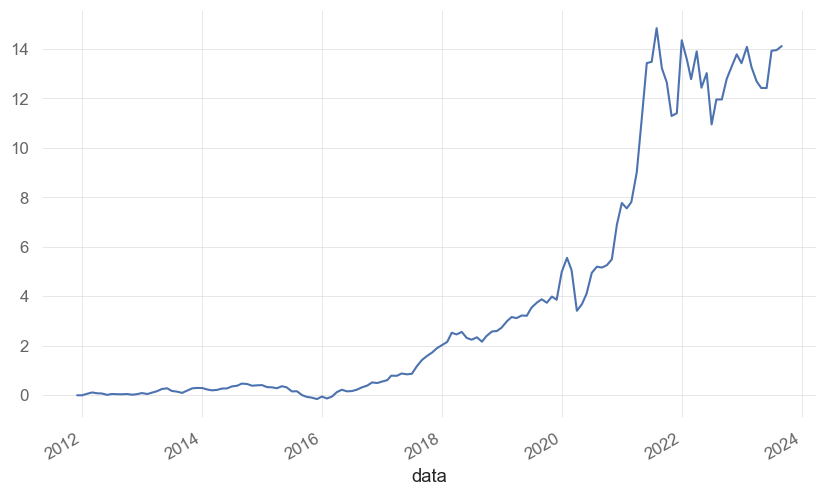

In [37]:
rentabilidade_carteira['retorno_modelo'].plot()

**Importação das cotações do Ibovespa, filtragem pelo mesmo período da base de dados das ações e cálculo da rentabilidade acumulada**

In [38]:
ibov = yf.download('^BVSP', '2009-01-01', '2023-10-18')
ibov.index = pd.to_datetime(ibov.index)
mask = ibov.index.isin(dados_empresas_filtrado.index)
filtered_ibov = ibov[mask]

retornos_ibov = filtered_ibov['Adj Close'].pct_change().dropna()
retorno_acumulado_ibov = (1 + retornos_ibov).cumprod() - 1

rentabilidade_carteira['ibovespa'] = retorno_acumulado_ibov.values
rentabilidade_carteira = rentabilidade_carteira.drop('retorno_medio_mensal', axis = 1)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-10-31,59513.0,59513.0,58094.0,58338.0,58338.0,2258000
2011-11-30,55307.0,57592.0,55307.0,56875.0,56875.0,4893000
2011-12-29,56534.0,56945.0,56313.0,56754.0,56754.0,2779200
2012-01-31,62772.0,63394.0,62664.0,63072.0,63072.0,3437800
2012-02-29,65970.0,66662.0,65533.0,65812.0,65812.0,3345400


**Gráfico do retorno acumulado do modelo _versus_ Ibovespa no período**

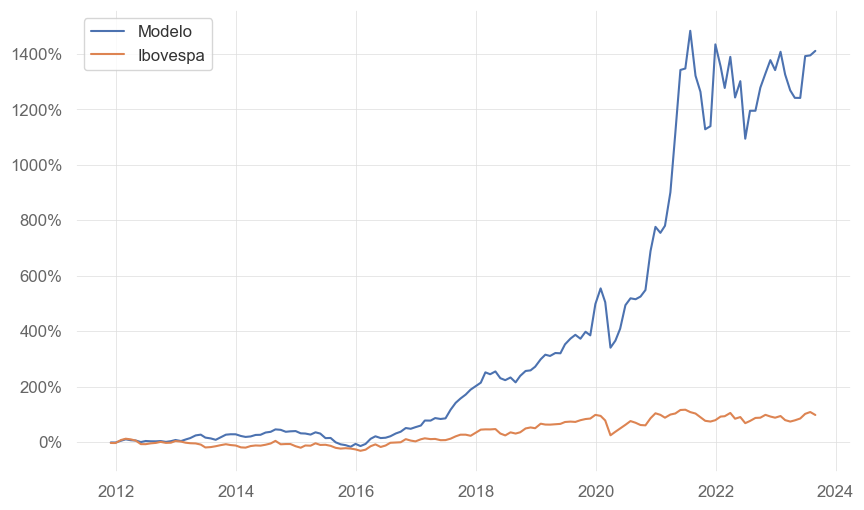

In [47]:
fig, ax = plt.subplots()
ax.plot(rentabilidade_carteira.index, rentabilidade_carteira['retorno_modelo'], label = 'Modelo')
ax.plot(rentabilidade_carteira.index, rentabilidade_carteira['ibovespa'], label = 'Ibovespa')
ax.legend(loc = 'upper left')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))